In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import poisson
from scipy.stats import chisquare
from pprint import pprint

#set seeds
np.random.seed(42)


In [2]:
df = pd.read_csv("data/japan_n_skorea.csv")

In [3]:
df.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2024-09-24T06:00:53.328Z,31.3961,140.0063,62.992,4.6,mb,40.0,134.0,4.664,0.89,...,2024-09-24T06:34:59.040Z,"Izu Islands, Japan region",earthquake,11.04,8.591,0.105,27.0,reviewed,us,us
1,2024-09-23T23:14:19.526Z,31.5463,140.0638,11.710,5.6,mww,110.0,86.0,1.579,1.07,...,2024-09-24T13:57:02.040Z,"Izu Islands, Japan region",earthquake,7.31,4.231,0.053,34.0,reviewed,us,us
2,2024-09-21T15:57:50.402Z,31.1565,140.9208,40.337,4.4,mb,67.0,132.0,2.167,0.54,...,2024-09-21T18:51:42.040Z,"Izu Islands, Japan region",earthquake,5.78,7.628,0.076,51.0,reviewed,us,us
3,2024-09-20T12:22:20.539Z,33.2622,132.2763,50.692,4.9,mb,75.0,56.0,1.416,0.92,...,2024-09-21T04:48:46.731Z,"26 km SW of Yawatahama, Japan",earthquake,5.90,6.386,0.038,225.0,reviewed,us,us
4,2024-09-19T09:18:10.282Z,35.6655,140.9251,43.764,4.6,mb,37.0,119.0,2.367,1.65,...,2024-09-19T11:13:06.040Z,"11 km SE of Hasaki, Japan",earthquake,7.18,7.662,0.105,27.0,reviewed,us,us


In [4]:
def time_difference(time:pd.Series):
    """
    This function calculates the time difference between the current time and the next time.
    :param time: 
    :return: 
    """
    time_diff = time - time.shift(1)
    return time_diff



def process_time(time:pd.Series):
    """
    This function processes the time series data.
    :param time: 
    :return: 
    """
    time = pd.to_datetime(time)
    time = time.sort_values()
    dt = time_difference(time)
    dt = dt.dt.total_seconds()
    dt = dt[dt > 0].reset_index(drop=True)
    return dt


In [5]:
def analyze_distributions(X, significance=0.05):
    """
    This function analyzes the distribution of the data.
    :param X: time difference between the current time and the next time.
    :return: results of the analysis and the output parameters.
    """
    results = []
    output_parameters = {}

    # Uniform distribution
    fit_uniform_dist = stats.uniform(loc=(X.min()), scale=X.max() - X.min())
    test = stats.kstest(X, fit_uniform_dist.cdf)
    p_value = test[1]
    fit_status = "Good fit" if p_value > significance else "Bad fit"
    results.append(["Uniform Distribution", fit_status, p_value])
    output_parameters["Uniform Distribution"] = ({
        "loc": X.min(),
        "scale": X.max() - X.min()
    })

    # Exponential distribution
    m1 = np.mean(X)
    fit_exponential_dist = stats.expon(scale=1 / m1)
    test = stats.kstest(X, fit_exponential_dist.cdf)
    p_value = test[1]
    fit_status = "Good fit" if p_value > significance else "Bad fit"
    results.append(["Exponential Distribution", fit_status, p_value])
    output_parameters["Exponential Distribution"] = ({
        "estimated_lambda": 1 / m1
    })

    # Gamma distribution
    m2 = np.mean([x ** 2 for x in X])
    est_beta = m1 / (m2 - m1 ** 2)
    est_alpha = m1 * est_beta
    fit_gamma_dist = stats.gamma(a=est_alpha, scale=1 / est_beta)
    test = stats.kstest(X, fit_gamma_dist.cdf)
    p_value = test[1]
    fit_status = "Good fit" if p_value > significance else "Bad fit"
    results.append(["Gamma Distribution", fit_status, p_value])
    output_parameters["Gamma Distribution"] = ({
        "estimated_alpha": est_alpha,
        "estimated_beta": est_beta
    })

    # Poisson distribution
    fi_poisson_dist = stats.poisson(mu=m1)
    test = stats.kstest(X, fi_poisson_dist.cdf)
    p_value = test[1]
    fit_status = "Good fit" if p_value > significance else "Bad fit"
    results.append(["Poisson Distribution", fit_status, p_value])
    output_parameters["Poisson Distribution"] = ({
        "estimated_lambda": m1
    })

    # Normal distribution
    estimated_std = m2 - m1 ** 2
    fit_normal_dist = stats.norm(loc=m1, scale=estimated_std)
    test = stats.kstest(X, fit_normal_dist.cdf)
    p_value = test[1]
    fit_status = "Good fit" if p_value > significance else "Bad fit"
    results.append(["Normal Distribution", fit_status, np.format_float_scientific(test[1], precision=2)])
    output_parameters["Normal Distribution"] = ({
        "estimated_mean": m1,
        "estimated_std": estimated_std
    })
    return results, output_parameters


In [6]:
def overlay_distribution_plot(X, output_parameters):
    """
    This function overlays the distribution plots.
    :return: 
    """
    
    n = len(X)
    exp_dist = np.random.exponential(output_parameters["Exponential Distribution"]["estimated_lambda"], n)
    gamma_dist = np.random.gamma(
        output_parameters["Gamma Distribution"]["estimated_alpha"],
        1 / output_parameters["Gamma Distribution"]["estimated_beta"],
        n)
    normal_dist = np.random.normal(
        output_parameters["Normal Distribution"]["estimated_mean"],
        output_parameters["Normal Distribution"]["estimated_std"],
        n)
    
    poisson_dist = np.random.poisson(output_parameters["Poisson Distribution"]["estimated_lambda"], n)
    uniform_dist = np.random.uniform(
        output_parameters["Uniform Distribution"]["loc"],
        output_parameters["Uniform Distribution"]["scale"],
        n)
    distributions = [exp_dist, gamma_dist, normal_dist, poisson_dist, uniform_dist]
    names = ["Exponential", "Gamma", "Normal", "Poisson", "Uniform"]
    
    
    fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(10, 25))
    
    for i, dist in enumerate(distributions):
        sns.histplot(dist, kde=True, ax=ax[i])
        sns.histplot(X, kde=True, ax=ax[i])
        ax[i].legend(["Fitted Distribution", "Data"])
        ax[i].set_title(f"{names[i]} Distribution")
        ax[i].set_xlabel("Time Difference")
        ax[i].set_ylabel("Frequency")
    
    # add title
    fig.suptitle("Overlay Distribution Plot", fontsize=16)
    
    
    # plt.tight_layout()
    plt.show()
    
    
    

In [7]:
def main(time):
    dt = process_time(time)
    results, output_parameters = analyze_distributions(dt)
    overlay_distribution_plot(dt, output_parameters)
    return results, output_parameters
    
    


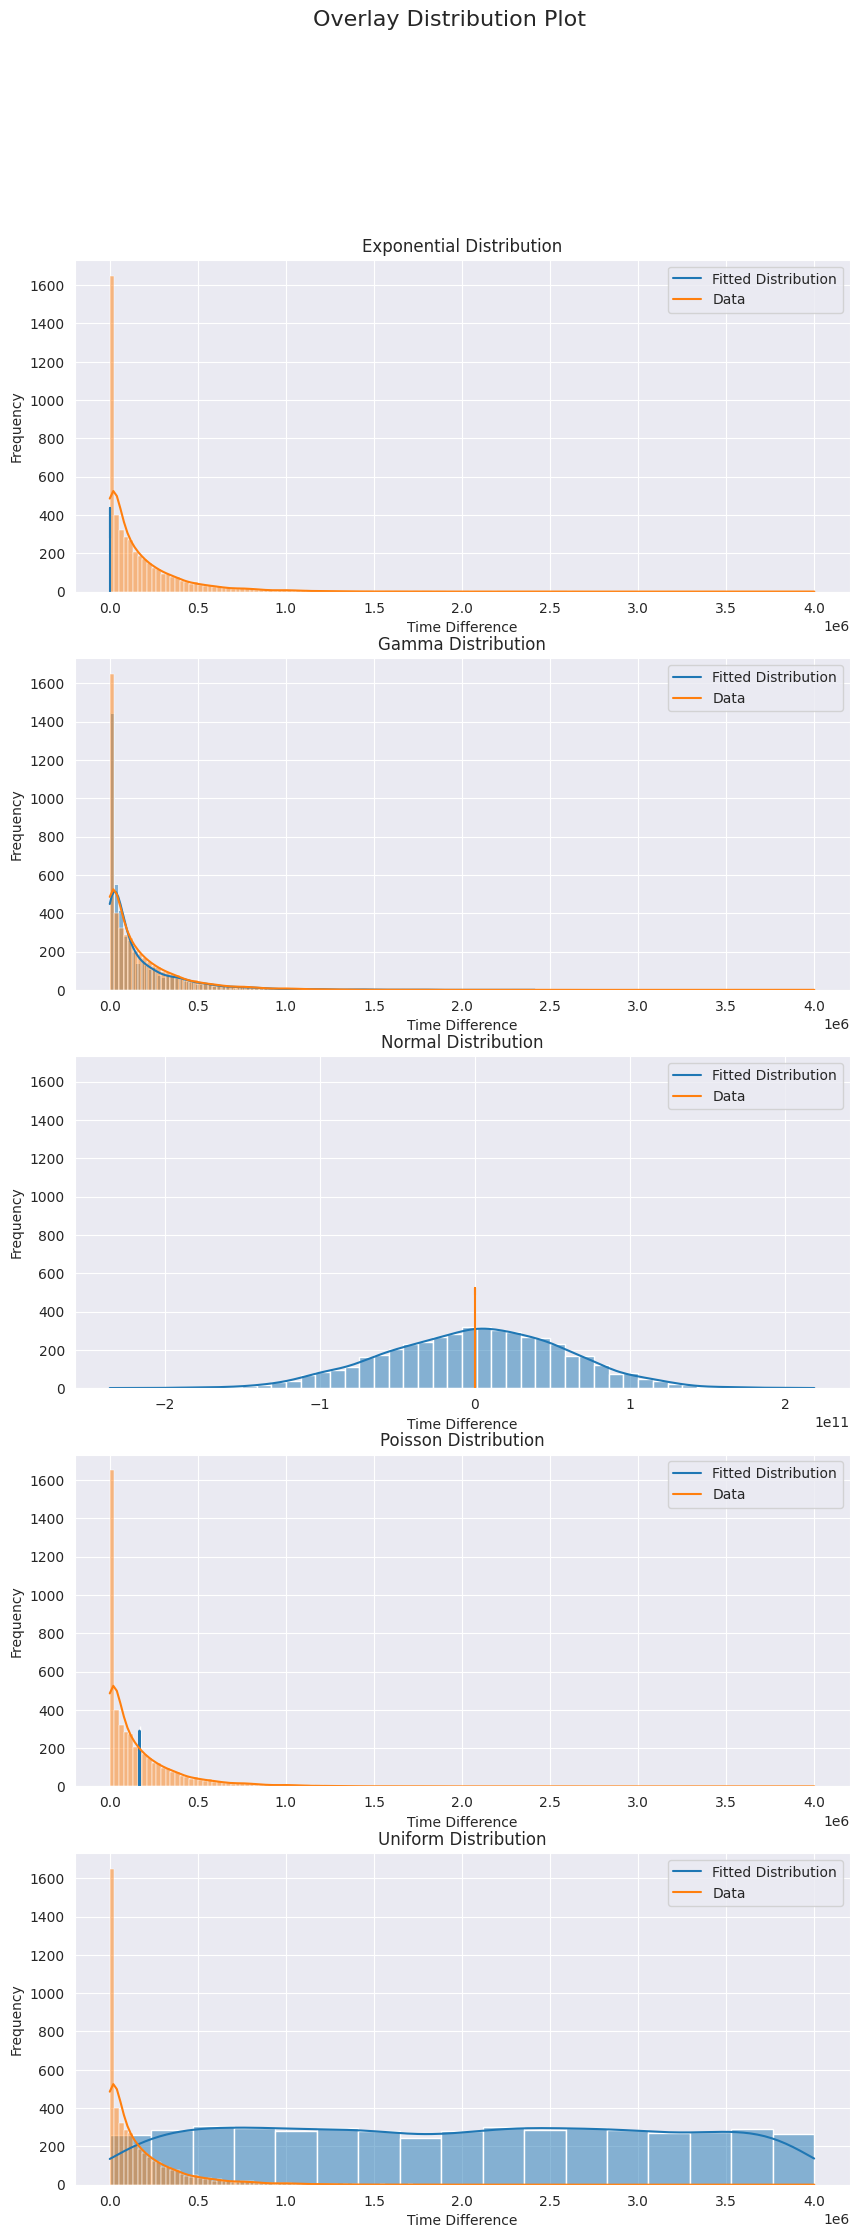

In [8]:

# all earthquake
results_all_eq, params_all_eq = main(df["time"])



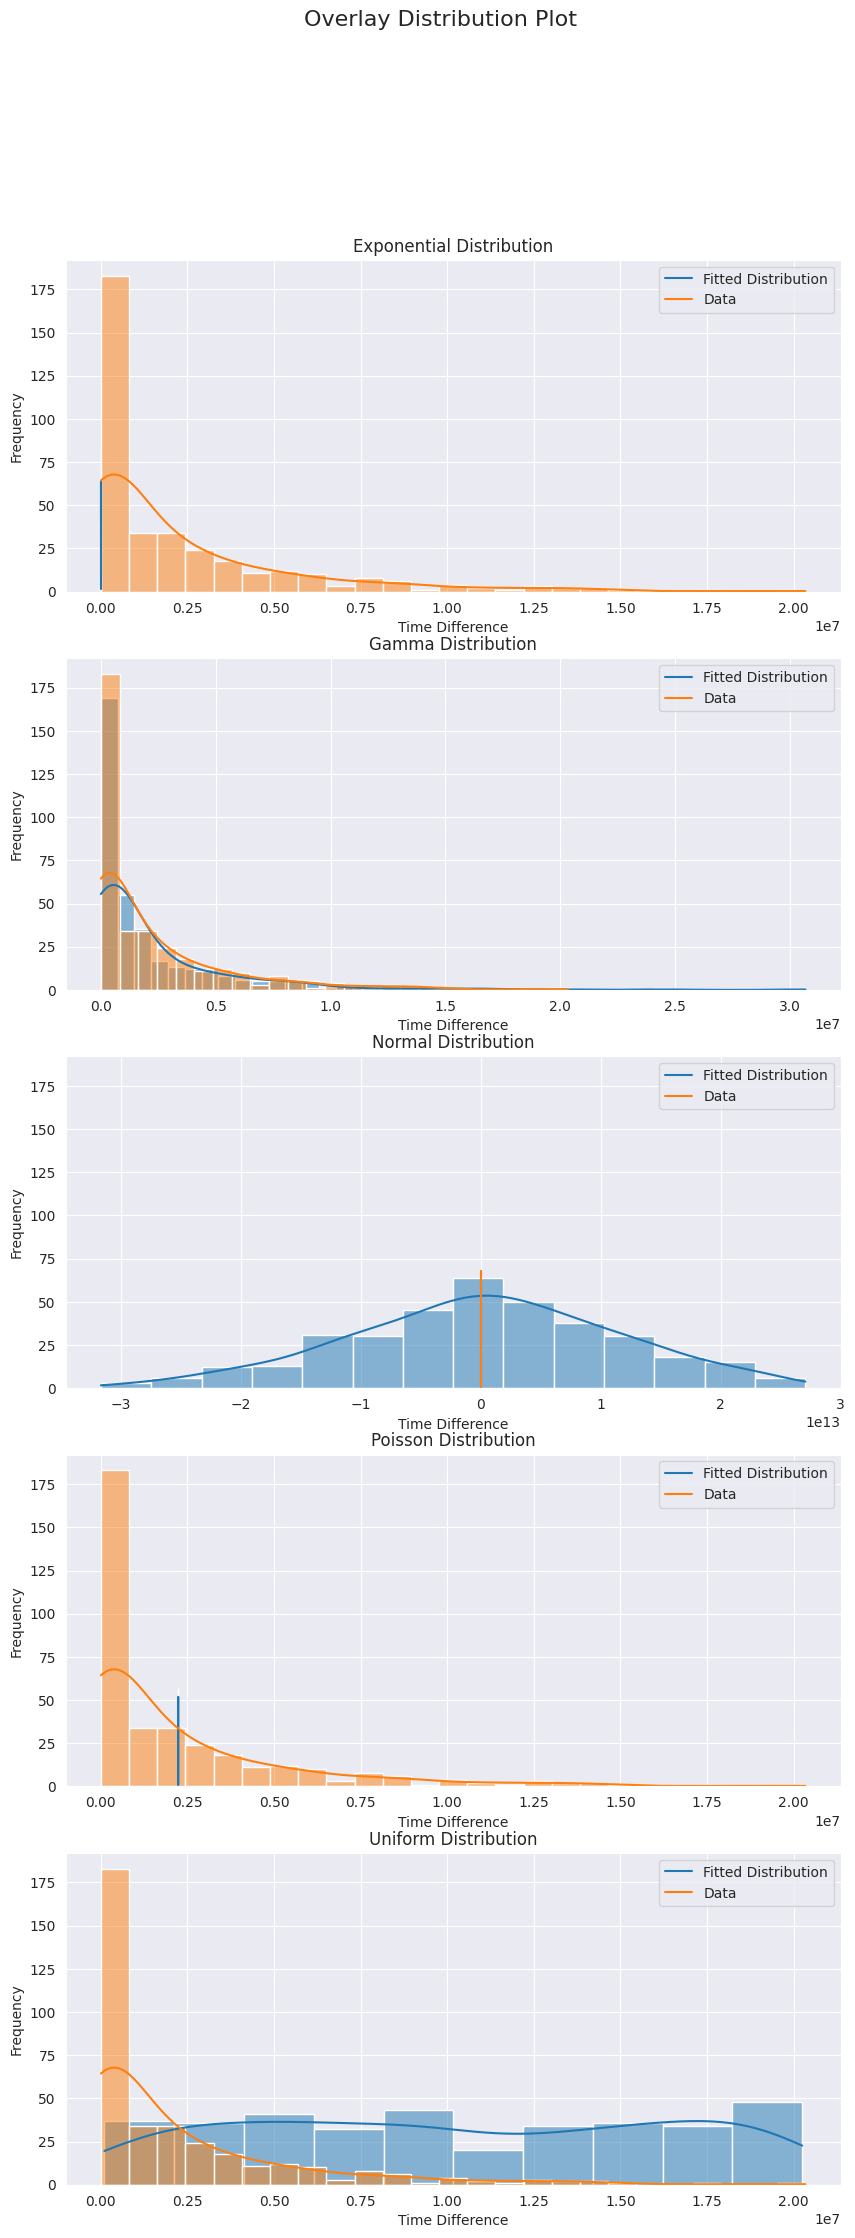

In [9]:

# Earthquakes with magnitude greater than 5
results_big_eq, params_bigw_eq = main(df[df["mag"] > 5]["time"])

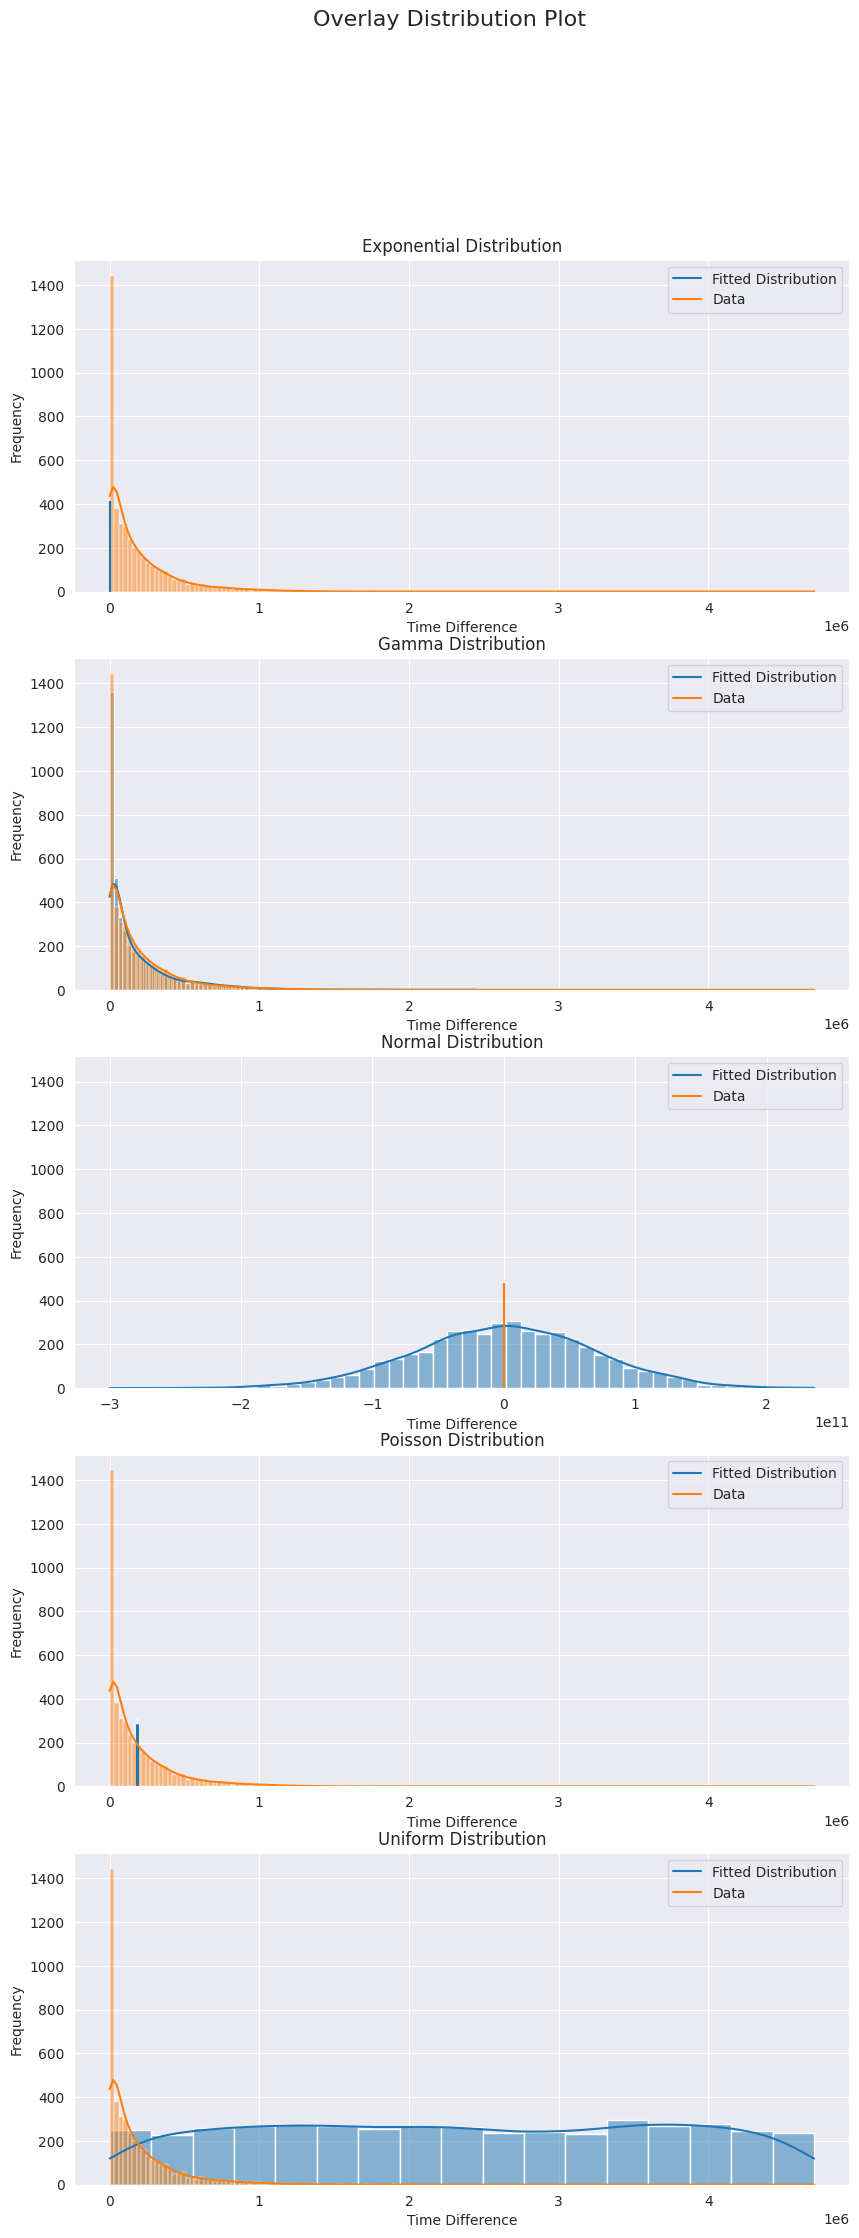

In [10]:

    
# Earthquakes with magnitude less than 5
results_sm_eq, params_sm_eq = main(df[df["mag"] < 5]["time"])
    
    
    
    
    
    
